# Entanglement Purification
This script purifies entanglement between two pairs of entangled qbits with an initial fidelity to the EPR pair of less than 1. The output state has a higher fidelity with the EPR pair and a higher concurrence.

In [1]:
#importing necessary modules
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'svg' # Saves plots in svg format

# qiskit modules
import qiskit
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_state_city, plot_state_paulivec
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity, concurrence, DensityMatrix

# tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

# readout calibration
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [2]:
# importing IBMQ backends
from qiskit import IBMQ
ibmq_provider = IBMQ.load_account()
device = ibmq_provider.get_backend('ibmqx2')

# necessary imports for noise modelling
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

## Defining the desired entangled state

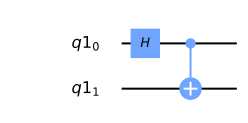

In [3]:
qreg = QuantumRegister(4)
qreg_exp = QuantumRegister(2)
qc_desired = QuantumCircuit(qreg_exp)
qc_desired.h(0)
qc_desired.cx(0,1)
qc_desired.draw(output='mpl')

The desired state is: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


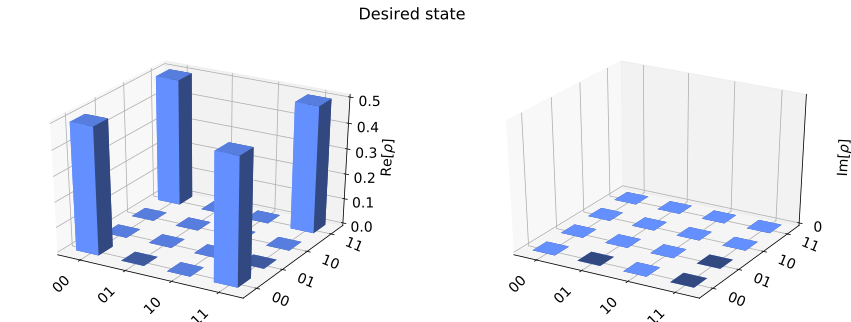

In [4]:
job = qiskit.execute(qc_desired, Aer.get_backend('statevector_simulator'))
psi_desired = job.result().get_statevector(qc_desired)
print('The desired state is:', psi_desired)
plot_state_city(psi_desired, title='Desired state')

## Creating the initial state
In order to check that we have improved on the initial state below we save it

In [5]:
# setting the initial Fidelity
F = 0.75
theta = np.arcsin(2*F - 1)

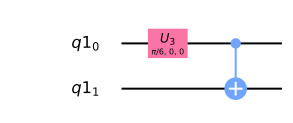

In [6]:
qc_intial = QuantumCircuit(qreg_exp)
qc_intial.u3(theta, 0, 0, 0)
qc_intial.cx(0,1)
qc_intial.draw(output='mpl')

The initial state is: [0.96592583+0.j 0.        +0.j 0.        +0.j 0.25881905+0.j]


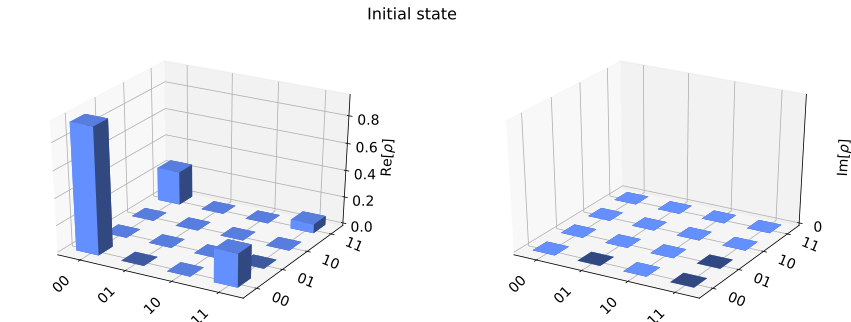

In [7]:
job = qiskit.execute(qc_intial, Aer.get_backend('statevector_simulator'))
psi_initial = job.result().get_statevector(qc_intial)
print('The initial state is:', psi_initial)
plot_state_city(psi_initial, title='Initial state')

## Defining the main circuit

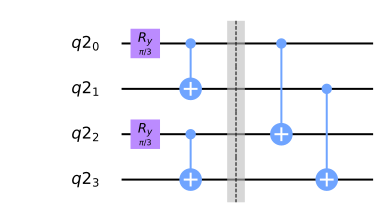

In [8]:
qr = QuantumRegister(4)
qc = QuantumCircuit(qr)

qc.ry(np.pi/3, 0)
qc.ry(np.pi/3, 2)
qc.cx(qr[0], qr[1])
qc.cx(qr[2], qr[3])
qc.barrier()

qc.cx(qr[0], qr[2])
qc.cx(qr[1], qr[3])

qc.draw(output='mpl')

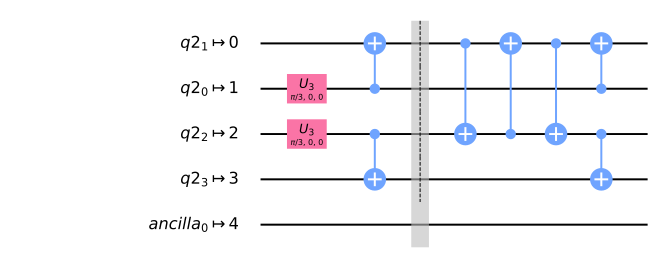

In [9]:
# what does this circuit look like on the device?
transpile_qc = qiskit.compiler.transpile(qc,device)
transpile_qc.draw(output='mpl')

## Readout correction
Performing calibration on the top two qbits of the circuit only

Job Status: job has successfully run


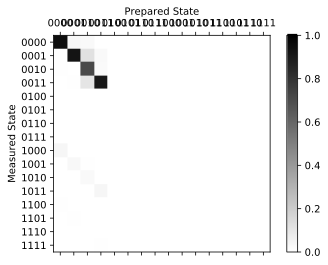

In [10]:
#readout calibration measurements
clz, state_labels = complete_meas_cal(qr = qc.qregs[0], circlabel = 'measerrormitcal')
# doing calibration only for qbit 0 and 1, for 00, 10, 01, 11
cal_circuit = [clz[0], clz[1], clz[2], clz[3]]
cal_job = qiskit.execute(cal_circuit, backend = device, shots = 8192, optimization_level = 0)
job_monitor(cal_job)
calres = cal_job.result()
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()

In [11]:
bits = ['0000', '0010', '0001', '0011', 
        '0100', '0110', '0101', '0111',
        '1000', '1010', '1001', '1011', 
        '1100', '1110', '1101', '1111']

counts = [0,0,0,0]
for i in range(4):
    counts[i] = calres.get_counts(cal_circuit[i])
    for bit in bits:
        if bit not in counts[i]:
            counts[i][bit] = 0

m_IZ = [0,0,0,0]
m_ZI = [0,0,0,0]
m_ZZ = [0,0,0,0]
for i in range(4):
    for num, bit in enumerate(bits):
        if num % 4 == 0 or num % 4 == 2:
            m_IZ[i] += float(counts[i][bit]) / 8192
        if num % 4 == 1 or num % 4 == 3:
            m_IZ[i] -= float(counts[i][bit]) / 8192
        if num % 4 == 0 or num % 4 == 1:
            m_ZI[i] += float(counts[i][bit]) / 8192
        if num % 4 == 2 or num % 4 == 3:
            m_ZI[i] -= float(counts[i][bit]) / 8192
        if num % 4 == 0 or num % 4 == 3:
            m_ZZ[i] += float(counts[i][bit]) / 8192
        if num % 4 == 1 or num % 4 == 2:
            m_ZZ[i] -= float(counts[i][bit]) / 8192

M = [[1,  1,  1,  1], 
     [1,  1, -1, -1], 
     [1, -1,  1, -1], 
     [1, -1, -1,  1]]
Minv = np.linalg.inv(M)

beta_IZ = np.dot(Minv, m_IZ)
beta_ZI = np.dot(Minv, m_ZI)
beta_ZZ = np.dot(Minv, m_ZZ)

b_vec = [beta_IZ[0], beta_ZI[0], beta_ZZ[0]]
B = [beta_IZ[1:], beta_ZI[1:], beta_ZZ[1:]]
Binv = np.linalg.inv(B)

[array([ 0.90307617,  0.06201172, -0.0625    ]), array([0.11743164, 0.85351562, 0.10595703]), array([-0.02819824,  0.0645752 ,  0.88195801])]
[0.08251953125, -0.087890625, 0.0587158203125]


## State Tomography
In order to reconstruct the output state of the circuit, it is necessary to perform 2 qbit tomography to build an arbitrary state from the outcomes of a series of measurements that together give the full state. For 2 qbits, that is 9 (3^n) circuits.

In [12]:
# defining tomography circuits
qcz = state_tomography_circuits(qc,qr)
# qiskit creates all 81 tomography circuits for 4 qbits, we want just a subset of that
qst_circuit = [qcz[8],qcz[17],qcz[26],qcz[35],qcz[44],qcz[53],qcz[62],qcz[71],qcz[80]]

In [13]:
backends = ['simulator', 'simulator_noise', device]

paulis = [('X','X','Z','Z'),('X','Y','Z','Z'),('X','Z','Z','Z'),
         ('Y','X','Z','Z'),('Y','Y','Z','Z'),('Y','Z','Z','Z'),
         ('Z','X','Z','Z'),('Z','Y','Z','Z'),('Z','Z','Z','Z')]

basis = ['XX','YX','ZX',
         'XY','YY','ZY',
         'XZ','YZ','ZZ']

for num, backend in enumerate(backends):
    state ={}
    for bas in basis:
        state.update({bas: {'00': 0, '01': 0, '10': 0, '11': 0}})
    state_df = pd.DataFrame(data=[state,state,state,state])
    
    if num == 0:
        job_sim = qiskit.execute(qst_circuit, Aer.get_backend('qasm_simulator'), shots=8192)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 1:
        job_sim_noise = qiskit.execute(qst_circuit, Aer.get_backend('qasm_simulator'), shots=8192,
                                 noise_model=noise_model, 
                                 coupling_map=coupling_map, 
                                 basis_gates=basis_gates)
        tom = StateTomographyFitter(job_sim_noise.result(), qst_circuit)
    if num == 2:
        job_dev = qiskit.execute(qst_circuit, backend, shots=8192)
        job_monitor(job_dev)
        tom = StateTomographyFitter(job_dev.result(), qst_circuit)
    
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit] = 0
    
    # we save the data for all outcomes then choose only the outcome '11', which is
    # the condition for purification to have succeeded, later
    for i in range(4):
        for j in range(9):
            state_df.loc[i][basis[j]] = {'00': tom.data[(paulis[j])][bits[4*i]],
                                         '01': tom.data[(paulis[j])][bits[4*i+2]],
                                         '10': tom.data[(paulis[j])][bits[4*i+1]],
                                         '11': tom.data[(paulis[j])][bits[4*i+3]]}

    if num == 0:
        state_sim = state_df
        print('Simulator done.')
    if num == 1:
        state_sim_noise = state_df
        print('Noisy simulator done.')
    if num == 2:
        state_dev = state_df
        print('Device done.')

Simulator done.
Noisy simulator done.
Job Status: job has successfully run
Device done.


In [14]:
# defining the matrices to construct the density matrices
I_matrix = np.matrix('1, 0; 0, 1')
X_matrix = np.matrix('0, 1; 1, 0')
Y_matrix = np.matrix('0, 0-1j; 0+1j, 0')
Z_matrix = np.matrix('1, 0; 0, -1')

Iden = np.kron(I_matrix,I_matrix)

IXPaul = np.kron(I_matrix,X_matrix)
IYPaul = np.kron(I_matrix,Y_matrix)
IZPaul = np.kron(I_matrix,Z_matrix)
XIPaul = np.kron(X_matrix,I_matrix)
YIPaul = np.kron(Y_matrix,I_matrix)
ZIPaul = np.kron(Z_matrix,I_matrix)

XXPaul = np.kron(X_matrix,X_matrix)
XYPaul = np.kron(X_matrix,Y_matrix)
XZPaul = np.kron(X_matrix,Z_matrix)

YXPaul = np.kron(Y_matrix,X_matrix)
YYPaul = np.kron(Y_matrix,Y_matrix)
YZPaul = np.kron(Y_matrix,Z_matrix)

ZXPaul = np.kron(Z_matrix,X_matrix)
ZYPaul = np.kron(Z_matrix,Y_matrix)
ZZPaul = np.kron(Z_matrix,Z_matrix)

In [15]:
# there are 4 density matrices to calculate for each of sim, sim_noise and dev

# XX, XY, XZ etc are 9 total r_xx etc terms to calculate
r_exp = np.zeros((9))
# there are three IX type terms and each can be calculated three ways (from XX, YX, ZX for IX)
r_IP = np.zeros((9))
r_PI = np.zeros((9))
r_IPavg = np.zeros((3))
r_PIavg = np.zeros((3))

m = np.zeros((9,3))
r_corr = np.zeros((9,3))
r_IPavg_corr = np.zeros((3))
r_PIavg_corr = np.zeros((3))

state_tot=[state_sim,state_sim_noise,state_dev]
rho=[0,0,0,0]

for stat, states in enumerate(state_tot):
    for j in range(9):
        r_exp[j] = (states[basis[j]][3]['00']*1 + states[basis[j]][3]['10']*(-1) + states[basis[j]][3]['01']*(-1) + states[basis[j]][3]['11']*1)/(states[basis[j]][3]['00']*1 + states[basis[j]][3]['10']*(1) + states[basis[j]][3]['01']*(1) + states[basis[j]][3]['11']*1)
        r_IP[j] = (states[basis[j]][3]['00']*1 + states[basis[j]][3]['10']*(1) + states[basis[j]][3]['01']*(-1) + states[basis[j]][3]['11']*(-1))/(states[basis[j]][3]['00']*1 + states[basis[j]][3]['10']*(1) + states[basis[j]][3]['01']*(1) + states[basis[j]][3]['11']*1)
        r_PI[j] = (states[basis[j]][3]['00']*1 + states[basis[j]][3]['10']*(-1) + states[basis[j]][3]['01']*(1) + states[basis[j]][3]['11']*(-1))/(states[basis[j]][3]['00']*1 + states[basis[j]][3]['10']*(1) + states[basis[j]][3]['01']*(1) + states[basis[j]][3]['11']*1)  

    for j in range(3):
            r_IPavg[j]  = (r_IP[j] + r_IP[j+3] + r_IP[j+6])/3
            r_PIavg[j] = (r_PI[3*j] + r_PI[3*j+1] + r_PI[3*j+2])/3
            
    rho[stat] = (1/4)*(Iden + r_exp[0]*XXPaul + r_exp[1]*XYPaul + r_exp[2]*XZPaul
                          + r_exp[3]*YXPaul + r_exp[4]*YYPaul + r_exp[5]*YZPaul
                          + r_exp[6]*ZXPaul + r_exp[7]*ZYPaul + r_exp[8]*ZZPaul
                          + r_IPavg[0]*IXPaul + r_PIavg[0]*XIPaul
                          + r_IPavg[1]*IYPaul + r_PIavg[1]*YIPaul
                          + r_IPavg[2]*IZPaul + r_PIavg[2]*ZIPaul)

    # performing corrections for readout error and storing result in another density matrix
    for num, bas in enumerate(basis):
        m[num,:] = [r_IP[num], r_PI[num], r_exp[num]]
        r_corr[num] = np.dot(Binv, np.subtract(m[num,:],b_vec))

for j in range(3):
        r_IPavg_corr[j] = (r_corr[j][0] + r_corr[j+3][0] + r_corr[j+6][0])/3
        r_PIavg_corr[j] = (r_corr[3*j][1] + r_corr[3*j+1][1] + r_corr[3*j+2][1])/3

rho_corr = (1/4)*(Iden + r_corr[0][2]*XXPaul + r_corr[1][2]*XYPaul + r_corr[2][2]*XZPaul
                          + r_corr[3][2]*YXPaul + r_corr[4][2]*YYPaul + r_corr[5][2]*YZPaul
                          + r_corr[6][2]*ZXPaul + r_corr[7][2]*ZYPaul + r_corr[8][2]*ZZPaul
                          + r_IPavg_corr[0]*IXPaul + r_PIavg_corr[0]*XIPaul
                          + r_IPavg_corr[1]*IYPaul + r_PIavg_corr[1]*YIPaul
                          + r_IPavg_corr[2]*IZPaul + r_PIavg_corr[2]*ZIPaul)

rho[3] = rho_corr

## Calculating Fidelities

In [26]:
F = [0,0,0,0,0]
for i in range(4):
    F[i] = state_fidelity(psi_desired, rho[i], validate=False)

F[4] = state_fidelity(psi_desired,psi_initial, validate=False)

print('Input Fidelity:', F[4])
print('Simulator Fidelity:', F[0])
print('Noisy Simulator Fidelity:', F[1])
print('Device Fidelity:', F[2])
print('Calibrated Device Fidelity', F[3])

Input Fidelity: 0.7500000000000001
Simulator Fidelity: 1.0
Noisy Simulator Fidelity: 0.8298513602441739
Device Fidelity: 0.7724838087352052
Calibrated Device Fidelity 0.8299113574491628


## Visualizing Output States

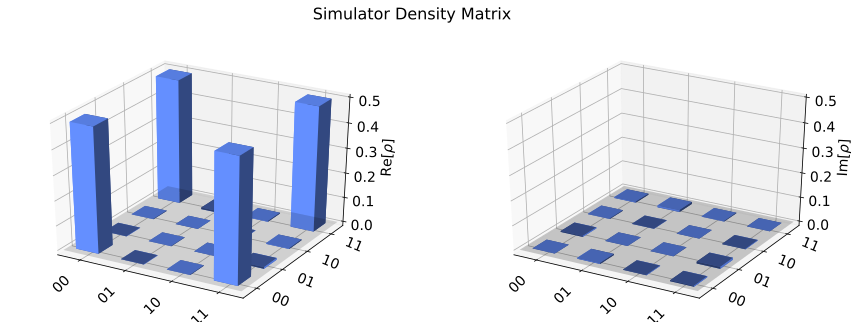

In [17]:
plot_state_city(rho[0], title='Simulator Density Matrix')

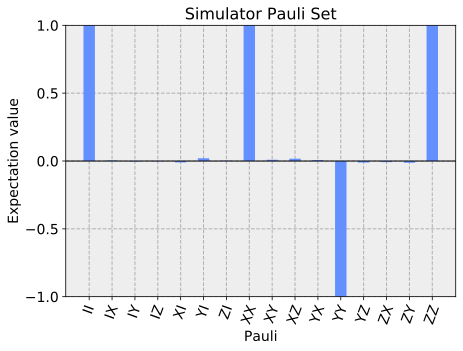

In [18]:
plot_state_paulivec(rho[0], title='Simulator Pauli Set')

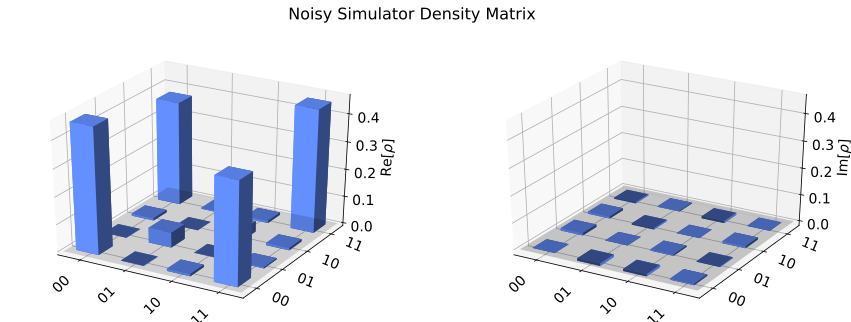

In [19]:
plot_state_city(rho[1], title='Noisy Simulator Density Matrix')

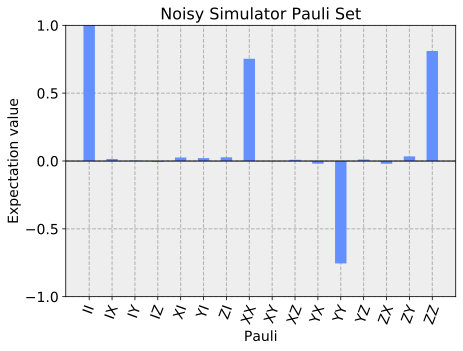

In [20]:
plot_state_paulivec(rho[1], title='Noisy Simulator Pauli Set')

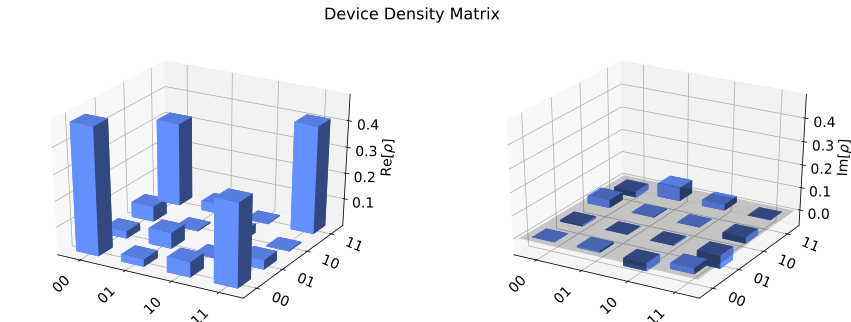

In [21]:
plot_state_city(rho[2], title='Device Density Matrix')

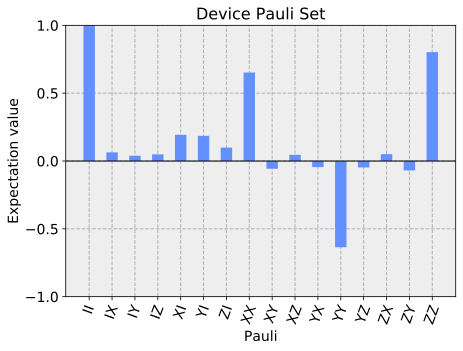

In [22]:
plot_state_paulivec(rho[2], title='Device Pauli Set')

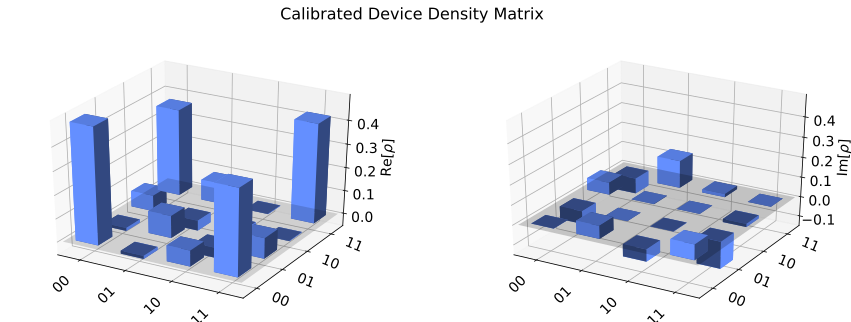

In [23]:
plot_state_city(rho[3], title='Calibrated Device Density Matrix')

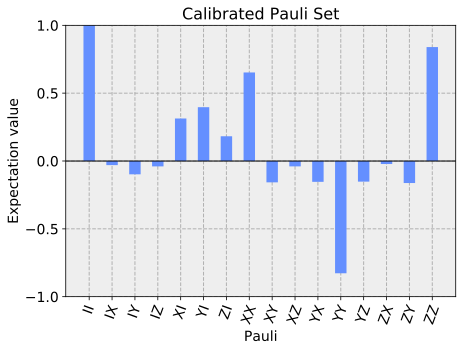

In [24]:
plot_state_paulivec(rho[3], title='Calibrated Pauli Set')

In [25]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.12.0',
 'qiskit-aer': '0.4.0',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.5.0',
 'qiskit-aqua': '0.6.4',
 'qiskit': '0.16.0'}